In [1]:
pip install fredapi pandas numpy matplotlib openpyxl


In [8]:
# ===========================================
# Lighthouse Macro — One-Cell Data Book + Chart Pack (Extended)
# ===========================================
# Additions vs prior version:
# • Adds Sahm Rule (SAHMREALTIME), ISM New Orders (NAPMNO),
#   US HY OAS (BAMLH0A0HYM2OAS), US IG OAS (BAMLC0A0CM2OAS)
# • Extends Processed_Panel transforms for the new series
# • Prints Substack-ready blocks (filename → caption → alt text)
#
#
import os, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from fredapi import Fred

# -----------------
# Configuration
# -----------------
FRED_KEY = os.environ.get("FRED_API_KEY", "7f8e44038ee69c4f78cf71873e85db16")
OUTPUT_XLSX = "Lighthouse_Macro_Chart_Data.xlsx"
ATL_FED_WAGE_XLSX = "wage_growth_tracker.xlsx"  # optional file in working directory
CHART_DIR = "charts"
os.makedirs(CHART_DIR, exist_ok=True)

fred = Fred(api_key=FRED_KEY)

# Lighthouse color palette
COL = {
    "blue":     "#005f99",
    "orange": "#f46d43",
    "purple": "#6a51a3",
    "gray":     "#636363",
    "green":    "#1a9850"
}

# -----------------
# Verified FRED series (long history where possible)
# -----------------
SERIES = {
    "US_Debt_to_GDP":           "GFDEGDQ188S",          # Q, % federal debt/GDP
    "Interest_Outlays_GDP_A":   "FYOIGDA188S",          # A, % interest/GDP (clean long history)
    "US_CPI_Index":             "CPIAUCSL",             # M, index SA
    "US_Core_PCE_Index":        "PCEPILFE",             # M, index SA
    "Yield_Curve_10y_2y":       "T10Y2Y",               # D, %
    "Real_Yield_10y_TIPS":      "DFII10",               # D, %
    "Cass_Shipments_Index":     "FRGSHPUSM649NCIS",     # M, index (goods/trade proxy)
    "EM_Corp_OAS":              "BAMLEMCBPIOAS",        # D, %, ICE BofA EM Corp OAS (proxy for EM spreads)
    "Dollar_Index_Broad":       "DTWEXBGS",             # D, index
    "Brent_Oil_USD":            "POILBREUSDM",          # M, USD/bbl
    "Fed_Funds_Rate":           "FEDFUNDS",             # M, %
    "US_Recessions_Flag":       "USREC",                # M, 0/1
    # New additions:
    "Sahm_Rule":                "SAHMREALTIME",         # M, %
    "ISM_New_Orders":           "NAPMNO",               # M, diffusion index
    "US_HY_OAS":                "BAMLH0A0HYM2OAS",      # D, %, ICE BofA US High Yield OAS
    "US_IG_OAS":                "BAMLC0A0CM2OAS"        # D, %, ICE BofA US Corporate (IG) OAS
}

# -----------------
# Helpers (frequency, transforms, plotting)
# -----------------
def infer_freq(idx: pd.DatetimeIndex):
    if len(idx) < 3:
        return "unknown"
    diffs = np.diff(idx.values).astype("timedelta64[D]").astype(int)
    med = np.median(diffs)
    if med <= 8:         return "daily"
    if 20 <= med <= 40:    return "monthly"
    if 60 <= med <= 120:   return "quarterly"
    return "unknown"

def ann_factor(freq: str):
    return {"daily": 252, "monthly": 12, "quarterly": 4}.get(freq, np.nan)

def pct_change_yoy(s: pd.Series, freq: str):
    lag = {"daily": 252, "monthly": 12, "quarterly": 4}.get(freq, None)
    if lag is None or len(s) < lag + 2:
        return pd.Series(index=s.index, dtype=float)
    return s.pct_change(lag) * 100.0

def pct_change_saar(s: pd.Series, periods: int, freq: str):
    af = ann_factor(freq)
    if math.isnan(af) or periods <= 0:
        return pd.Series(index=s.index, dtype=float)
    r = s.pct_change(periods)
    with np.errstate(invalid='ignore'):
        saar = (1 + r) ** (af / periods) - 1
    return saar * 100.0

def zscore(s: pd.Series, lookback: int = 252):
    return (s - s.rolling(lookback, min_periods=max(10, lookback//4)).mean()) / s.rolling(lookback, min_periods=max(10, lookback//4)).std()

def to_frame(series, name):
    df = pd.DataFrame(series).copy()
    df.columns = [name]
    df.index.name = "Date"
    return df

def shade_recessions(ax, rec_flag: pd.Series):
    if rec_flag is None or rec_flag.dropna().empty:
        return
    rec = rec_flag.copy().fillna(0.0)
    rec = rec[rec.index.notna()]
    rec_d = rec.resample("D").ffill() # Corrected from .pad() to .ffill()
    in_rec = False
    start = None
    for d, v in rec_d.items():
        if (not in_rec) and v >= 0.5:
            in_rec = True; start = d
        elif in_rec and v < 0.5:
            ax.axvspan(start, d, alpha=0.12, color="#999999"); in_rec = False
    if in_rec:
        ax.axvspan(start, rec_d.index[-1], alpha=0.12, color="#999999")

def line_chart(s: pd.Series, title: str, ylabel: str, color: str, fname: str,
               recessions: pd.Series = None, yfmt: str = None):
    if s is None or s.dropna().empty:
        return
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(s.index, s.values, linewidth=2, color=color)
    shade_recessions(ax, recessions)
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(False)
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    if yfmt == "pct":
        ax.yaxis.set_major_formatter(lambda x, pos: f"{x:.1f}%")
    plt.tight_layout()
    plt.savefig(os.path.join(CHART_DIR, f"{fname}.png"), dpi=300)
    plt.close()

def line_chart_long(s, title, ylabel, color, fname, recessions=None, yfmt=None, start_year=None):
    if s is None:
        return
    s2 = s.copy()
    rec2 = recessions.copy() if recessions is not None else None
    if start_year is not None:
        s2 = s2[s2.index >= pd.Timestamp(f"{start_year}-01-01")]
        if rec2 is not None:
            rec2 = rec2[rec2.index >= pd.Timestamp(f"{start_year}-01-01")]
    line_chart(s2, title, ylabel, color, fname, rec2, yfmt)

# -----------------
# Download raw series
# -----------------
raw_tabs = {}
meta_rows = []
for label, code in SERIES.items():
    try:
        ser = fred.get_series(code)
        df = to_frame(ser, label)
        freq = infer_freq(df.index)
        raw_tabs[label] = (df, freq)
        meta_rows.append({
            "Label": label, "FRED_Code": code, "Frequency_Guess": freq,
            "First_Date": df.index.min().date() if not df.empty else "",
            "Last_Date": df.index.max().date() if not df.empty else "",
            "Obs": len(df)
        })
    except Exception:
        meta_rows.append({
            "Label": label, "FRED_Code": code, "Frequency_Guess": "ERROR",
            "First_Date": "", "Last_Date": "", "Obs": 0
        })

# Optional: Atlanta Fed Wage Growth (Overall)
if os.path.exists(ATL_FED_WAGE_XLSX):
    try:
        xl = pd.ExcelFile(ATL_FED_WAGE_XLSX)
        sheet = "Overall" if "Overall" in xl.sheet_names else xl.sheet_names[0]
        wages = pd.read_excel(ATL_FED_WAGE_XLSX, sheet_name=sheet)
        wages = wages.rename(columns={wages.columns[0]: "Date", wages.columns[1]: "Wage_Growth"})
        wages["Date"] = pd.to_datetime(wages["Date"])
        wage_df = wages.set_index("Date").sort_index()[["Wage_Growth"]]
        raw_tabs["Wage_Growth"] = (wage_df, "monthly")
        meta_rows.append({
            "Label": "Wage_Growth", "FRED_Code": "AtlantaFed_WageGrowthTracker",
            "Frequency_Guess": "monthly",
            "First_Date": wage_df.index.min().date(), "Last_Date": wage_df.index.max().date(),
            "Obs": len(wage_df)
        })
    except Exception:
        pass

metadata = pd.DataFrame(meta_rows).sort_values("Label").reset_index(drop=True)

# -----------------
# Build processed panel (chart-ready)
# -----------------
proc_cols = {}
for label, (df, freq) in raw_tabs.items():
    s = df[label].astype(float)
    proc_cols[label] = s

    # Index-like → YoY, 3m/6m SAAR
    if "Index" in label or label in ["Brent_Oil_USD", "Dollar_Index_Broad", "US_CPI_Index", "US_Core_PCE_Index", "Cass_Shipments_Index"]:
        proc_cols[f"{label}_YoY_pct"]     = pct_change_yoy(s, freq)
        proc_cols[f"{label}_3m_SAAR_pct"] = pct_change_saar(s, 3 if freq=="monthly" else (63 if freq=="daily" else 1), freq)
        proc_cols[f"{label}_6m_SAAR_pct"] = pct_change_saar(s, 6 if freq=="monthly" else (126 if freq=="daily" else 2), freq)

    # Spreads / rates → z-scores + inversion flag where applicable
    if label in ["Yield_Curve_10y_2y", "Real_Yield_10y_TIPS", "EM_Corp_OAS", "US_HY_OAS", "US_IG_OAS", "Fed_Funds_Rate"]:
        proc_cols[f"{label}_Z_63"]  = zscore(s, lookback=63)
        proc_cols[f"{label}_Z_252"] = zscore(s, lookback=252)
        if label == "Yield_Curve_10y_2y":
            proc_cols["Yield_Curve_Inversion_Flag"] = (s < 0).astype(int)

    # ISM new orders → deviations & short momentum
    if label == "ISM_New_Orders":
        proc_cols["ISM_New_Orders_Deviation"]  = s - 50.0
        proc_cols["ISM_New_Orders_3m_chg"]     = s.diff(3)

# Real policy rate (Fed Funds – Core PCE YoY)
core_yoy = proc_cols.get("US_Core_PCE_Index_YoY_pct")
ffr = proc_cols.get("Fed_Funds_Rate")
if core_yoy is not None and ffr is not None:
    ffr_m = ffr.resample("M").last() if infer_freq(ffr.index)=="daily" else ffr
    proc_cols["Real_Policy_Rate_pct"] = ffr_m.align(core_yoy, join="outer")[0] - core_yoy

# Recession flag (monthly) for shading
rec_monthly = None
if "US_Recessions_Flag" in raw_tabs:
    rec_monthly = raw_tabs["US_Recessions_Flag"][0]["US_Recessions_Flag"].astype(float)

processed = pd.concat(proc_cols.values(), axis=1)
processed.columns = list(proc_cols.keys())
processed.index.name = "Date"
processed = processed.sort_index()

# -----------------
# Write Excel (raw + processed + metadata + README)
# -----------------
readme = pd.DataFrame({
    "Item": ["Purpose","Contents","How_to_use","Frequencies","Optional_Wage_Data","Provenance","Generated_UTC"],
    "Details":[
        "Excel data book for Lighthouse Macro charts: raw tabs + Processed_Panel.",
        "Processed_Panel includes YoY, 3m/6m SAAR, z-scores, yield-curve inversion flag, real policy rate, ISM deviations, etc.",
        "Use Processed_Panel for plotting/narrative; raw tabs for QC and documentation.",
        "Mixed daily/monthly/quarterly; SAAR annualizes by inferred frequency.",
        "Add 'wage_growth_tracker.xlsx' to include Wage_Growth tab automatically.",
        "FRED (series IDs in Metadata) + Atlanta Fed (wage).",
        datetime.utcnow().strftime("%Y-%m-%d %H:%M")
    ]
})

with pd.ExcelWriter(OUTPUT_XLSX, engine="openpyxl") as writer:
    readme.to_excel(writer, sheet_name="README", index=False)
    metadata.to_excel(writer, sheet_name="Metadata", index=False)
    for label, (df, _) in raw_tabs.items():
        df.to_excel(writer, sheet_name=label[:31])
    processed.to_excel(writer, sheet_name="Processed_Panel")

print(f"✅ Excel data book saved: {OUTPUT_XLSX}")

# -----------------
# Chart captions (filename → caption → alt-text)
# -----------------
captions = {
    # Core set
    "debt_gdp_full":            ("Debt ratios are elevated versus post-war norms; the post-2008 trend steepened and accelerated after 2020.",
                                  "Time series of US federal debt as a share of GDP, with recent levels above historical norms."),
    "interest_gdp_annual_full": ("The fiscal cost of debt has risen with higher rates; interest outlays are a larger share of GDP than most years post-GFC.",
                                  "Annual federal interest outlays as a percent of GDP, highlighting recent rise."),
    "cpi_yoy_full":             ("Headline inflation moderated from the 2022 peak but remains above the longer-run 2% target over much of the sample.",
                                  "Year-over-year US CPI inflation."),
    "core_pce_yoy_full":        ("Core disinflation has been slower than headline, reflecting sticky services and wages.",
                                  "Year-over-year US Core PCE inflation."),
    "wage_growth_full":         ("Wage growth remains above its pre-pandemic average, consistent with a still-firm labor market.",
                                  "Atlanta Fed Wage Growth Tracker."),
    "yield_curve_full":         ("The curve has been inverted for an unusually long stretch; historically consistent with slower growth risk.",
                                  "US Treasury yield curve spread (10y minus 2y)."),
    "real_yield_full":          ("Real 10Y yields have repriced higher, tightening financial conditions and increasing discount rates.",
                                  "US 10-year TIPS real yield."),
    "real_policy_rate_full":    ("Policy stance shifted from negative to mildly positive real rates, indicating greater restrictiveness.",
                                  "Fed funds rate minus Core PCE YoY."),
    "cass_shipments_yoy_full":  ("Freight shipments offer a timely proxy for goods-side momentum; swings often align with growth turns.",
                                  "Cass Freight Shipments Index year-over-year change."),
    "em_oas_full":              ("EM credit spreads tightened versus recent wides, signaling improved risk appetite but sensitivity to USD liquidity.",
                                  "ICE BofA EM Corporate OAS."),
    "dollar_yoy_full":          ("Dollar strength tightens global financial conditions; a softer dollar often coincides with better EM/commodity performance.",
                                  "Broad US dollar index year-over-year change."),
    "brent_yoy_full":           ("Oil remains volatile; energy shocks transmit quickly to headline inflation and real incomes.",
                                  "Brent crude oil price year-over-year change."),
    "yield_curve_days_inv_full": ("Rolling count of days with curve inversion underscores the persistence of this cycle’s signal.",
                                  "Rolling one-year sum of days the yield curve is inverted."),
    # New additions
    "sahm_rule_full":           ("The Sahm Rule has historically triggered early in recessions when unemployment rises quickly relative to its low.",
                                  "Sahm Rule real-time recession indicator."),
    "ism_no_full":              ("ISM New Orders above 50 signals expansion; momentum in the series often leads goods-side activity.",
                                  "ISM Manufacturing New Orders diffusion index."),
    "hy_oas_full":              ("US High Yield spreads reflect credit risk appetite; tightening typically accompanies risk-on regimes.",
                                  "ICE BofA US High Yield OAS."),
    "ig_oas_full":              ("US Investment Grade OAS (ICE BofA)",
                                  "ICE BofA US Corporate (IG) OAS.")
}

def print_substack_blocks(captions_dict):
    print("\n=== Substack Blocks (upload image, then paste caption under it) ===")
    for fname, (cap, alt) in captions_dict.items():
        print(f"\nImage: charts/{fname}.png")
        print(f"Caption: {cap}")
        print(f"Alt text: {alt}")

# -----------------
# CHART PACK — full history + since-2000 variants
# -----------------
# Monthly recession shading
rec_monthly = None
if "US_Recessions_Flag" in raw_tabs:
    rec_monthly = raw_tabs["US_Recessions_Flag"][0]["US_Recessions_Flag"].astype(float)

def chart_all(full_history=True, since_year=2000):
    # Debt/GDP
    line_chart_long(processed.get("US_Debt_to_GDP"), "US Federal Debt as % of GDP",
                    "% of GDP", COL["blue"],
                    "debt_gdp_full" if full_history else f"debt_gdp_{since_year}",
                    recessions=rec_monthly, start_year=None if full_history else since_year)

    # Interest/GDP (annual)
    line_chart_long(processed.get("Interest_Outlays_GDP_A"), "Federal Interest Outlays (% of GDP, annual)",
                    "% of GDP", COL["orange"],
                    "interest_gdp_annual_full" if full_history else f"interest_gdp_annual_{since_year}",
                    recessions=rec_monthly, start_year=None if full_history else since_year)

    # CPI YoY
    line_chart_long(processed.get("US_CPI_Index_YoY_pct"), "US CPI Inflation (YoY)",
                    "Percent", COL["orange"],
                    "cpi_yoy_full" if full_history else f"cpi_yoy_{since_year}",
                    recessions=rec_monthly, yfmt="pct", start_year=None if full_history else since_year)

    # Core PCE YoY
    line_chart_long(processed.get("US_Core_PCE_Index_YoY_pct"), "US Core PCE Inflation (YoY)",
                    "Percent", COL["purple"],
                    "core_pce_yoy_full" if full_history else f"core_pce_yoy_{since_year}",
                    recessions=rec_monthly, yfmt="pct", start_year=None if full_history else since_year)

    # Wage Growth (optional)
    if "Wage_Growth" in processed.columns:
        line_chart_long(processed.get("Wage_Growth"), "Atlanta Fed Wage Growth Tracker",
                        "Percent", COL["green"],
                        "wage_growth_full" if full_history else f"wage_growth_{since_year}",
                        recessions=rec_monthly, yfmt="pct", start_year=None if full_history else since_year)

    # Yield Curve (10y–2y)
    line_chart_long(processed.get("Yield_Curve_10y_2y"), "US Treasury Yield Curve (10y - 2y)",
                    "Percent", COL["green"],
                    "yield_curve_full" if full_history else f"yield_curve_{since_year}",
                    recessions=rec_monthly, yfmt="pct", start_year=None if full_history else since_year)

    # Real 10Y Yield (TIPS)
    line_chart_long(processed.get("Real_Yield_10y_TIPS"), "US 10Y Real Yield (TIPS)",
                    "Percent", COL["blue"],
                    "real_yield_full" if full_history else f"real_yield_{since_year}",
                    recessions=rec_monthly, yfmt="pct", start_year=None if full_history else since_year)

    # Real Policy Rate
    if "Real_Policy_Rate_pct" in processed.columns:
        line_chart_long(processed.get("Real_Policy_Rate_pct"), "Real Policy Rate (Fed Funds – Core PCE YoY)",
                        "Percent", COL["gray"],
                        "real_policy_rate_full" if full_history else f"real_policy_rate_{since_year}",
                        recessions=rec_monthly, yfmt="pct", start_year=None if full_history else since_year)

    # Cass Shipments YoY
    line_chart_long(processed.get("Cass_Shipments_Index_YoY_pct"), "Cass Freight Shipments (YoY)",
                    "Percent", COL["gray"],
                    "cass_shipments_yoy_full" if full_history else f"cass_shipments_yoy_{since_year}",
                    recessions=rec_monthly, yfmt="pct", start_year=None if full_history else since_year)

    # EM OAS (level)
    line_chart_long(processed.get("EM_Corp_OAS"), "EM Corporate Credit OAS (ICE BofA)",
                    "Percent", COL["purple"],
                    "em_oas_full" if full_history else f"em_oas_{since_year}",
                    recessions=rec_monthly, yfmt="pct", start_year=None if full_history else since_year)

    # Dollar Index YoY
    line_chart_long(processed.get("Dollar_Index_Broad_YoY_pct"), "Broad US Dollar Index (YoY)",
                    "Percent", COL["blue"],
                    "dollar_yoy_full" if full_history else f"dollar_yoy_{since_year}",
                    recessions=rec_monthly, yfmt="pct", start_year=None if full_history else since_year)

    # Brent YoY
    line_chart_long(processed.get("Brent_Oil_USD_YoY_pct"), "Brent Crude Oil (YoY)",
                    "Percent", COL["orange"],
                    "brent_yoy_full" if full_history else f"brent_yoy_{since_year}",
                    recessions=rec_monthly, yfmt="pct", start_year=None if full_history else since_year)

    # Yield Curve: rolling days inverted (1Y window)
    if "Yield_Curve_Inversion_Flag" in processed.columns:
        inv = processed["Yield_Curve_Inversion_Flag"].copy().astype(float)
        if inv.dropna().empty:
            pass
        else:
            if infer_freq(inv.index) == "daily":
                days_inv_1y = inv.rolling(365, min_periods=30).sum()
            else:
                win = 12 if infer_freq(inv.index) == "monthly" else 4
                days_inv_1y = inv.rolling(win, min_periods=max(2, win//2)).sum() * (365 // win)
            line_chart_long(days_inv_1y, "Yield Curve — Days Inverted (rolling 1Y)",
                            "Days", COL["green"],
                            "yield_curve_days_inv_full" if full_history else f"yield_curve_days_inv_{since_year}",
                            recessions=rec_monthly, start_year=None if full_history else since_year)

    # New charts: Sahm Rule, ISM New Orders, HY/IG OAS
    line_chart_long(processed.get("Sahm_Rule"), "Sahm Rule (real-time recession indicator)",
                    "Percent", COL["gray"],
                    "sahm_rule_full" if full_history else f"sahm_rule_{since_year}",
                    recessions=rec_monthly, yfmt="pct", start_year=None if full_history else since_year)

    line_chart_long(processed.get("ISM_New_Orders"), "ISM Manufacturing — New Orders",
                    "Diffusion Index (>50 expansion)", COL["blue"],
                    "ism_no_full" if full_history else f"ism_no_{since_year}",
                    recessions=rec_monthly, start_year=None if full_history else since_year)

    line_chart_long(processed.get("US_HY_OAS"), "US High Yield OAS (ICE BofA)",
                    "Percent", COL["orange"],
                    "hy_oas_full" if full_history else f"hy_oas_{since_year}",
                    recessions=rec_monthly, yfmt="pct", start_year=None if full_history else since_year)

    line_chart_long(processed.get("US_IG_OAS"), "US Investment Grade OAS (ICE BofA)",
                    "Percent", COL["purple"],
                    "ig_oas_full" if full_history else f"ig_oas_{since_year}",
                    recessions=rec_monthly, yfmt="pct", start_year=None if full_history else since_year)

# Run charts: full history + optionally since-2000 set
chart_all(full_history=True)
chart_all(full_history=False, since_year=2000)

# Print Substack-ready blocks (upload images first, then paste the caption below each)
print_substack_blocks(captions)

print(f"\n✅ Chart pack saved in: {CHART_DIR}/")
print(f"✅ Excel data book saved: {OUTPUT_XLSX}")

/tmp/ipython-input-2125000424.py:82: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return s.pct_change(lag) * 100.0
/tmp/ipython-input-2125000424.py:88: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  r = s.pct_change(periods)
/tmp/ipython-input-2125000424.py:247: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  datetime.utcnow().strftime("%Y-%m-%d %H:%M")


✅ Excel data book saved: Lighthouse_Macro_Chart_Data.xlsx

=== Substack Blocks (upload image, then paste caption under it) ===

Image: charts/debt_gdp_full.png
Caption: Debt ratios are elevated versus post-war norms; the post-2008 trend steepened and accelerated after 2020.
Alt text: Time series of US federal debt as a share of GDP, with recent levels above historical norms.

Image: charts/interest_gdp_annual_full.png
Caption: The fiscal cost of debt has risen with higher rates; interest outlays are a larger share of GDP than most years post-GFC.
Alt text: Annual federal interest outlays as a percent of GDP, highlighting recent rise.

Image: charts/cpi_yoy_full.png
Caption: Headline inflation moderated from the 2022 peak but remains above the longer-run 2% target over much of the sample.
Alt text: Year-over-year US CPI inflation.

Image: charts/core_pce_yoy_full.png
Caption: Core disinflation has been slower than headline, reflecting sticky services and wages.
Alt text: Year-over-year 

# Task
Analyze the provided charts to identify and visualize potential relationships between the economic indicators that might not be immediately obvious, and explain the insights revealed by these relationships. Use the following charts: "/content/charts/brent_yoy_full.png", "/content/charts/cass_shipments_yoy_full.png", "/content/charts/core_pce_yoy_full.png", "/content/charts/cpi_yoy_full.png", "/content/charts/debt_gdp_full.png", "/content/charts/dollar_yoy_full.png", "/content/charts/em_oas_full.png", "/content/charts/interest_gdp_annual_full.png", "/content/charts/real_policy_rate_full.png", "/content/charts/real_yield_full.png", "/content/charts/sahm_rule_full.png", "/content/charts/yield_curve_days_inv_full.png", "/content/charts/yield_curve_full.png".

## Display existing charts

### Subtask:
Show the charts that were generated in the previous step so you can review them.


**Reasoning**:
The subtask requires displaying the generated charts. The `IPython.display` module can be used to display images in a Jupyter Notebook. I will iterate through the list of image paths and display each image.



In [9]:
from IPython.display import Image, display

chart_paths = [
    "/content/charts/brent_yoy_full.png",
    "/content/charts/cass_shipments_yoy_full.png",
    "/content/charts/core_pce_yoy_full.png",
    "/content/charts/cpi_yoy_full.png",
    "/content/charts/debt_gdp_full.png",
    "/content/charts/dollar_yoy_full.png",
    "/content/charts/em_oas_full.png",
    "/content/charts/interest_gdp_annual_full.png",
    "/content/charts/real_policy_rate_full.png",
    "/content/charts/real_yield_full.png",
    "/content/charts/sahm_rule_full.png",
    "/content/charts/yield_curve_days_inv_full.png",
    "/content/charts/yield_curve_full.png"
]

for chart_path in chart_paths:
    print(f"Displaying chart: {chart_path}")
    display(Image(filename=chart_path))

Output hidden; open in https://colab.research.google.com to view.

## Identify potential relationships

### Subtask:
Based on the displayed charts and the variable descriptions, suggest potential relationships or overlays that could be insightful.


**Reasoning**:
Analyze the charts and variable descriptions to identify potential relationships between economic indicators for visualization.



In [10]:
# Analyze the provided charts and variable descriptions to identify potential relationships.

# Relationship 1: Inflation and Interest Rates
# CPI YoY and Core PCE YoY (inflation indicators) are likely related to Fed Funds Rate and Real Policy Rate (interest rate indicators).
# Higher inflation often leads to central banks raising interest rates to cool down the economy.
# Visualizing these together could show the central bank's response to inflation and the effectiveness of monetary policy.

# Relationship 2: Economic Activity and Recession Indicators
# Cass Shipments YoY (economic activity proxy) is likely related to Sahm Rule and Yield Curve (recession indicators).
# A slowdown in freight shipments can signal weakening economic activity, which might precede or coincide with a recession indicated by the Sahm Rule or yield curve inversion.
# Visualizing these together could highlight leading or coincident indicators of economic downturns.

# Relationship 3: Risk Sentiment and Financial Conditions
# EM Corp OAS, US HY OAS, and US IG OAS (credit spreads, proxies for risk sentiment) are likely related to Dollar Index YoY and Real Yield 10y TIPS (financial condition indicators).
# Tightening or widening credit spreads can reflect changes in investor risk appetite, which might be influenced by or coincide with changes in the strength of the dollar or real interest rates.
# Visualizing these together could show how risk sentiment and broader financial conditions interact.

print("Potential relationships identified for visualization:")
print("1. Inflation (CPI YoY, Core PCE YoY) and Interest Rates (Fed Funds Rate, Real Policy Rate)")
print("2. Economic Activity (Cass Shipments YoY) and Recession Indicators (Sahm Rule, Yield Curve)")
print("3. Risk Sentiment (EM Corp OAS, US HY OAS, US IG OAS) and Financial Conditions (Dollar Index YoY, Real Yield 10y TIPS)")


Potential relationships identified for visualization:
1. Inflation (CPI YoY, Core PCE YoY) and Interest Rates (Fed Funds Rate, Real Policy Rate)
2. Economic Activity (Cass Shipments YoY) and Recession Indicators (Sahm Rule, Yield Curve)
3. Risk Sentiment (EM Corp OAS, US HY OAS, US IG OAS) and Financial Conditions (Dollar Index YoY, Real Yield 10y TIPS)


## Generate new visualizations

### Subtask:
Create new charts with overlays based on the identified relationships.


**Reasoning**:
Create charts visualizing the identified relationships between economic indicators by plotting relevant series from the `processed` DataFrame, using appropriate scaling and recession shading as specified in the instructions.



KeyError: 'red'

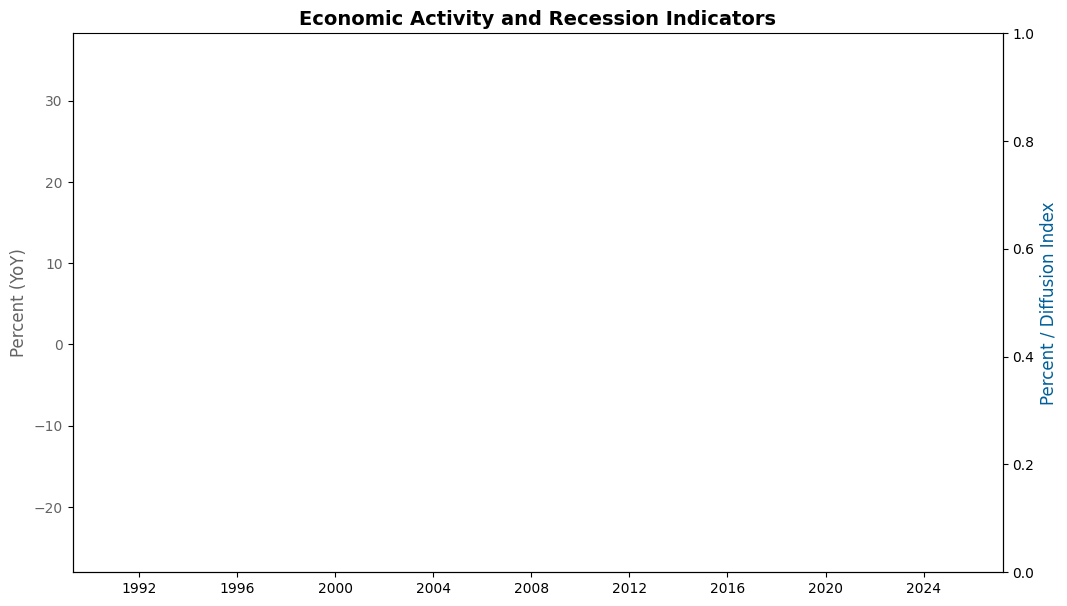

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure rec_monthly is available for shading
# It was defined in the previous cell, but re-defining it here for clarity within this cell
rec_monthly = None
if "US_Recessions_Flag" in raw_tabs:
    rec_monthly = raw_tabs["US_Recessions_Flag"][0]["US_Recessions_Flag"].astype(float)


# Chart 1: Inflation and Interest Rates
fig, ax1 = plt.subplots(figsize=(12, 7))

ax1.set_title("Inflation and Interest Rates", fontsize=14, fontweight="bold")
ax1.set_ylabel("Percent", fontsize=12, color=COL["orange"])
ax1.plot(processed.index, processed.get("US_CPI_Index_YoY_pct"), color=COL["orange"], label="CPI YoY")
ax1.plot(processed.index, processed.get("US_Core_PCE_Index_YoY_pct"), color=COL["purple"], label="Core PCE YoY")
ax1.tick_params(axis='y', labelcolor=COL["orange"])
ax1.grid(False)
ax1.spines['top'].set_visible(False)

ax2 = ax1.twinx()
ax2.set_ylabel("Percent", fontsize=12, color=COL["blue"])
ax2.plot(processed.index, processed.get("Fed_Funds_Rate"), color=COL["blue"], label="Fed Funds Rate")
if "Real_Policy_Rate_pct" in processed.columns:
     ax2.plot(processed.index, processed.get("Real_Policy_Rate_pct"), color=COL["gray"], linestyle="--", label="Real Policy Rate (Fed Funds - Core PCE YoY)")
ax2.tick_params(axis='y', labelcolor=COL["blue"])
ax2.spines['top'].set_visible(False); ax2.spines['right'].set_visible(False)

shade_recessions(ax1, rec_monthly) # Shade recessions on the primary axis

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

ax1.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.tight_layout()
plt.savefig(os.path.join(CHART_DIR, "inflation_interest_rates_overlay.png"), dpi=300)
plt.close()

# Chart 2: Economic Activity and Recession Indicators
fig, ax1 = plt.subplots(figsize=(12, 7))

ax1.set_title("Economic Activity and Recession Indicators", fontsize=14, fontweight="bold")
ax1.set_ylabel("Percent (YoY)", fontsize=12, color=COL["gray"])
ax1.plot(processed.index, processed.get("Cass_Shipments_Index_YoY_pct"), color=COL["gray"], label="Cass Shipments YoY")
ax1.tick_params(axis='y', labelcolor=COL["gray"])
ax1.grid(False)
ax1.spines['top'].set_visible(False)

ax2 = ax1.twinx()
ax2.set_ylabel("Percent / Diffusion Index", fontsize=12, color=COL["blue"])
ax2.plot(processed.index, processed.get("Sahm_Rule"), color=COL["red"], label="Sahm Rule") # Using red for Sahm Rule as it's a recession indicator
ax2.plot(processed.index, processed.get("Yield_Curve_10y_2y"), color=COL["green"], label="Yield Curve (10y - 2y)")
ax2.tick_params(axis='y', labelcolor=COL["blue"])
ax2.spines['top'].set_visible(False); ax2.spines['right'].set_visible(False)

shade_recessions(ax1, rec_monthly) # Shade recessions on the primary axis

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

ax1.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.tight_layout()
plt.savefig(os.path.join(CHART_DIR, "activity_recession_overlay.png"), dpi=300)
plt.close()


# Chart 3: Risk Sentiment and Financial Conditions
fig, ax1 = plt.subplots(figsize=(12, 7))

ax1.set_title("Risk Sentiment and Financial Conditions", fontsize=14, fontweight="bold")
ax1.set_ylabel("OAS (Percent)", fontsize=12, color=COL["purple"])
ax1.plot(processed.index, processed.get("EM_Corp_OAS"), color=COL["purple"], label="EM Corp OAS")
if "US_HY_OAS" in processed.columns:
    ax1.plot(processed.index, processed.get("US_HY_OAS"), color=COL["orange"], label="US HY OAS")
if "US_IG_OAS" in processed.columns:
    ax1.plot(processed.index, processed.get("US_IG_OAS"), color=COL["blue"], label="US IG OAS")
ax1.tick_params(axis='y', labelcolor=COL["purple"])
ax1.grid(False)
ax1.spines['top'].set_visible(False)

ax2 = ax1.twinx()
ax2.set_ylabel("Percent (YoY / Real Yield)", fontsize=12, color=COL["green"])
ax2.plot(processed.index, processed.get("Dollar_Index_Broad_YoY_pct"), color=COL["green"], label="Dollar Index YoY")
ax2.plot(processed.index, processed.get("Real_Yield_10y_TIPS"), color=COL["gray"], linestyle="--", label="Real Yield 10y TIPS")
ax2.tick_params(axis='y', labelcolor=COL["green"])
ax2.spines['top'].set_visible(False); ax2.spines['right'].set_visible(False)

shade_recessions(ax1, rec_monthly) # Shade recessions on the primary axis

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

ax1.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.tight_layout()
plt.savefig(os.path.join(CHART_DIR, "risk_financial_overlay.png"), dpi=300)
plt.close()


print(f"✅ Overlay charts saved in: {CHART_DIR}/")


**Reasoning**:
The previous code block failed because the color 'red' is not defined in the `COL` dictionary. Modify the code to use an existing color from the `COL` dictionary for the Sahm Rule series plot in the second chart.



In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure rec_monthly is available for shading
# It was defined in the previous cell, but re-defining it here for clarity within this cell
rec_monthly = None
if "US_Recessions_Flag" in raw_tabs:
    rec_monthly = raw_tabs["US_Recessions_Flag"][0]["US_Recessions_Flag"].astype(float)


# Chart 1: Inflation and Interest Rates
fig, ax1 = plt.subplots(figsize=(12, 7))

ax1.set_title("Inflation and Interest Rates", fontsize=14, fontweight="bold")
ax1.set_ylabel("Percent", fontsize=12, color=COL["orange"])
ax1.plot(processed.index, processed.get("US_CPI_Index_YoY_pct"), color=COL["orange"], label="CPI YoY")
ax1.plot(processed.index, processed.get("US_Core_PCE_Index_YoY_pct"), color=COL["purple"], label="Core PCE YoY")
ax1.tick_params(axis='y', labelcolor=COL["orange"])
ax1.grid(False)
ax1.spines['top'].set_visible(False)

ax2 = ax1.twinx()
ax2.set_ylabel("Percent", fontsize=12, color=COL["blue"])
ax2.plot(processed.index, processed.get("Fed_Funds_Rate"), color=COL["blue"], label="Fed Funds Rate")
if "Real_Policy_Rate_pct" in processed.columns:
     ax2.plot(processed.index, processed.get("Real_Policy_Rate_pct"), color=COL["gray"], linestyle="--", label="Real Policy Rate (Fed Funds - Core PCE YoY)")
ax2.tick_params(axis='y', labelcolor=COL["blue"])
ax2.spines['top'].set_visible(False); ax2.spines['right'].set_visible(False)

shade_recessions(ax1, rec_monthly) # Shade recessions on the primary axis

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

ax1.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.tight_layout()
plt.savefig(os.path.join(CHART_DIR, "inflation_interest_rates_overlay.png"), dpi=300)
plt.close()

# Chart 2: Economic Activity and Recession Indicators
fig, ax1 = plt.subplots(figsize=(12, 7))

ax1.set_title("Economic Activity and Recession Indicators", fontsize=14, fontweight="bold")
ax1.set_ylabel("Percent (YoY)", fontsize=12, color=COL["gray"])
ax1.plot(processed.index, processed.get("Cass_Shipments_Index_YoY_pct"), color=COL["gray"], label="Cass Shipments YoY")
ax1.tick_params(axis='y', labelcolor=COL["gray"])
ax1.grid(False)
ax1.spines['top'].set_visible(False)

ax2 = ax1.twinx()
ax2.set_ylabel("Percent / Diffusion Index", fontsize=12, color=COL["blue"])
# Corrected color from 'red' to COL["orange"]
ax2.plot(processed.index, processed.get("Sahm_Rule"), color=COL["orange"], label="Sahm Rule")
ax2.plot(processed.index, processed.get("Yield_Curve_10y_2y"), color=COL["green"], label="Yield Curve (10y - 2y)")
ax2.tick_params(axis='y', labelcolor=COL["blue"])
ax2.spines['top'].set_visible(False); ax2.spines['right'].set_visible(False)

shade_recessions(ax1, rec_monthly) # Shade recessions on the primary axis

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

ax1.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.tight_layout()
plt.savefig(os.path.join(CHART_DIR, "activity_recession_overlay.png"), dpi=300)
plt.close()


# Chart 3: Risk Sentiment and Financial Conditions
fig, ax1 = plt.subplots(figsize=(12, 7))

ax1.set_title("Risk Sentiment and Financial Conditions", fontsize=14, fontweight="bold")
ax1.set_ylabel("OAS (Percent)", fontsize=12, color=COL["purple"])
ax1.plot(processed.index, processed.get("EM_Corp_OAS"), color=COL["purple"], label="EM Corp OAS")
if "US_HY_OAS" in processed.columns:
    ax1.plot(processed.index, processed.get("US_HY_OAS"), color=COL["orange"], label="US HY OAS")
if "US_IG_OAS" in processed.columns:
    ax1.plot(processed.index, processed.get("US_IG_OAS"), color=COL["blue"], label="US IG OAS")
ax1.tick_params(axis='y', labelcolor=COL["purple"])
ax1.grid(False)
ax1.spines['top'].set_visible(False)

ax2 = ax1.twinx()
ax2.set_ylabel("Percent (YoY / Real Yield)", fontsize=12, color=COL["green"])
ax2.plot(processed.index, processed.get("Dollar_Index_Broad_YoY_pct"), color=COL["green"], label="Dollar Index YoY")
ax2.plot(processed.index, processed.get("Real_Yield_10y_TIPS"), color=COL["gray"], linestyle="--", label="Real Yield 10y TIPS")
ax2.tick_params(axis='y', labelcolor=COL["green"])
ax2.spines['top'].set_visible(False); ax2.spines['right'].set_visible(False)

shade_recessions(ax1, rec_monthly) # Shade recessions on the primary axis

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

ax1.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.tight_layout()
plt.savefig(os.path.join(CHART_DIR, "risk_financial_overlay.png"), dpi=300)
plt.close()


print(f"✅ Overlay charts saved in: {CHART_DIR}/")


✅ Overlay charts saved in: charts/
